In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

import torch
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam import GradCAM

from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.plot_utils import plot_predictions
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from pipelines.utils.model_utils import DOMAIN_CONF

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')

In [3]:
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / "samples/rgb.png"
sample_depth = multimae_path / "samples/depth.npy"
sample_semseg = multimae_path / "samples/semseg.png"

In [4]:
# sample_rgb = flightmare_path.parent / "vis_attention/gradcam/samples/catdog.png"

(224, 224, 3)


(-0.5, 639.5, 479.5, -0.5)

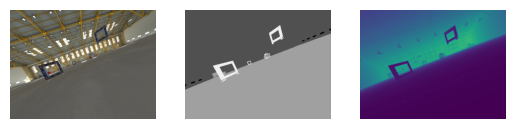

In [5]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

In [6]:
DOMAINS = ['rgb']

input_adapters = {
    domain: dinfo['input_adapter'](patch_size_full=16)
    for domain, dinfo in DOMAIN_CONF.items()
}

output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

model = pretrain_multimae_base(input_adapters=input_adapters, output_adapters=output_adapters)
CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.to("cuda")
model.eval()

MultiMAE(
  (input_adapters): ModuleDict(
    (rgb): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (depth): PatchedInputAdapter(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (semseg): SemSegInputAdapter(
      (class_emb): Embedding(133, 64)
      (proj): Conv2d(64, 768, kernel_size=(4, 4), stride=(4, 4))
    )
  )
  (output_adapters): ModuleDict(
    (rgb): SpatialOutputAdapter(
      (task_embeddings): ParameterDict(  (rgb): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)])
      (decoder): CrossAttention(
        (q): Linear(in_features=256, out_features=256, bias=True)
        (kv): Linear(in_features=256, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (context_norm): LayerNorm((256,), eps=1e-06, elementwise_aff

In [7]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

processed_inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True)
    
# To GPU
processed_inputs = {k: v.squeeze(-1).to("cuda") for k,v in processed_inputs.items()}

print(processed_inputs["rgb"].shape)
print(processed_inputs["depth"].shape)
print(processed_inputs["semseg"].shape)

inputs = {k: processed_inputs[k] for k in DOMAINS}

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


In [8]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        score = 0
        for k, v in self.features.items():
            score += torch.sum(cos(v, model_output[k]))
        return score

In [9]:
def reshape_transform(tensor, height=14, width=14):
    b, nt, nh = tensor.size()   # batch, num_tokens, num_hidden
    result = tensor[:, :-1 , :].reshape(b, height, width, nh)

    # Bring the channels to the first dimension, like in CNNs.
    result = result.permute(0, 3, 1, 2)
    return result

In [10]:
from multimae.utils.masking_generator import non_overlap_mask_gen

torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

mask = non_overlap_mask_gen(DOMAINS, num_encoded_tokens, patch_dims=(14, 14))

for k, v in mask.items():
    print(k, np.sum(v))
    print(v)
    
mask.update(
    {
        "depth": np.ones((14, 14)),
        "semseg": np.ones((14, 14))
    }
)
    
task_masks = {k: torch.LongTensor(v).flatten()[None].to(device) for k, v in mask.items()}

rgb 0.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


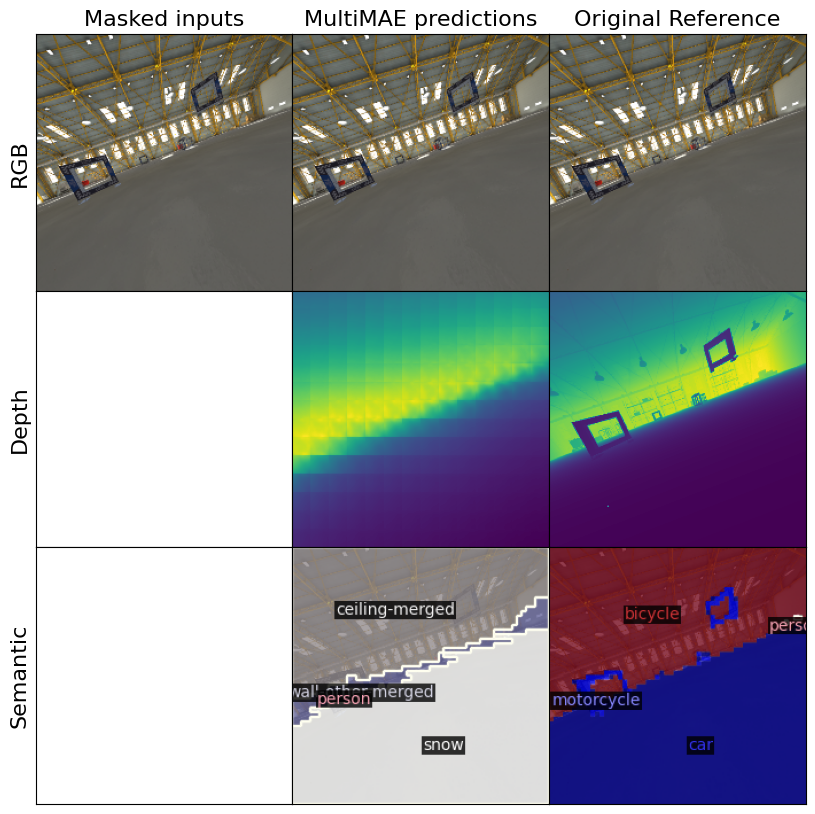

In [11]:
preds, masks = model(
    processed_inputs, 
    mask_inputs=True, # True if forward pass should sample random masks
    num_encoded_tokens=num_encoded_tokens,
    alphas=alphas,
    task_masks=task_masks,
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(processed_inputs, preds, masks)

In [12]:
target_layers = [model.encoder[-1].norm1]
tasks = {
    # "rgb": processed_inputs["rgb"], 
    "depth": processed_inputs["depth"],
    # "semseg": processed_inputs["semseg"]
}
targets = [SimilarityToConceptTarget(tasks)]

cam = GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=True,
             reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=inputs["rgb"], targets=targets, num_encoded_tokens=196)[0, :, :]
cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'Output')

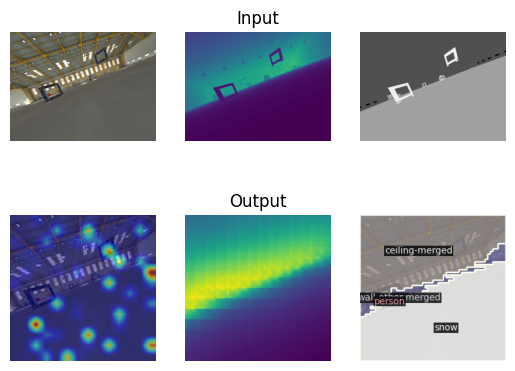

In [13]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(image)
axs[0, 0].axis('off')

axs[0, 1].imshow(depth)
axs[0, 1].axis('off')

axs[0, 2].imshow(semseg * 80)
axs[0, 2].axis('off')
axs[0, 1].set_title('Input')

axs[1, 0].imshow(cam_image)
axs[1, 0].axis('off')

axs[1, 1].imshow(res["depth_pred"])
axs[1, 1].axis('off')

axs[1, 2].imshow(res["semseg_pred"])
axs[1, 2].axis('off')
axs[1, 1].set_title('Output')